**Intro**

My first attempt at a Kaggle competition. Gets a reasonable score but would love some feedback on how it could be improved.

**Import everything**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler
from scipy import stats
from sklearn.model_selection import cross_val_score, train_test_split, KFold 
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, BayesianRidge
from sklearn.metrics import mean_squared_error, make_scorer, mean_squared_log_error
# from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
# from scipy.special import boxcox1p, inv_boxcox1p

%matplotlib inline

**Read CSV file**

In [2]:
df_initial_train = pd.read_csv('train.csv')
df_train = df_initial_train.copy()


In [3]:
df_initial_test = pd.read_csv('test.csv')
df_test = df_initial_test.copy()
df_train = pd.concat([df_train, df_test], ignore_index=True)


**Which features are correlated with each other?**

In [4]:
corrmat = df_train.drop('SalePrice', axis=1).corr()
indices = np.where(corrmat.abs() > 0.65)
indices = [(corrmat.index[x], corrmat.columns[y], corrmat.values[x][y])
           for x, y in zip(*indices) if x != y and x < y]
high_corr = pd.DataFrame(indices, columns=['Feature1', 'Feature2', 'Correlation'])
high_corr.sort_values('Correlation')

,Feature1,Feature2,Correlation
5,GarageYrBlt,YearRemodAdd,0.652365
1,2ndFlrSF,GrLivArea,0.655085
2,BedroomAbvGr,TotRmsAbvGrd,0.669737
0,1stFlrSF,TotalBsmtSF,0.801670
6,GrLivArea,TotRmsAbvGrd,0.808354
4,GarageYrBlt,YearBuilt,0.834812
3,GarageArea,GarageCars,0.889700


**Which features are correlated with SalePrice?**

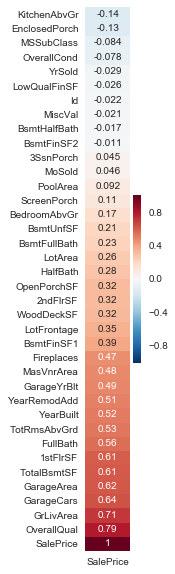

In [5]:
corrmat = df_train.corr()
indices = corrmat.loc[:,'SalePrice'].copy()
a = pd.DataFrame(indices.sort_values())
plt.figure(figsize=(1,10))
sns.heatmap(a, annot=True)

**Show me some plots**

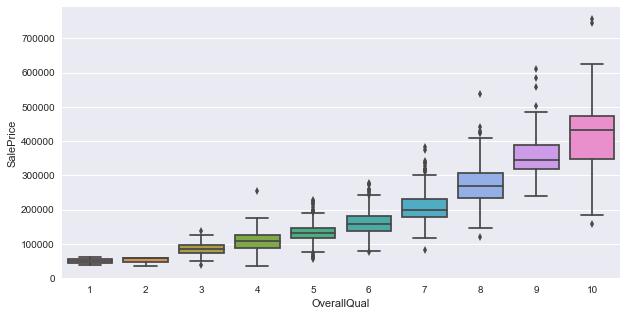

In [6]:
# box plot overallqual/saleprice
var = 'OverallQual'
data = pd.concat([df_initial_train['SalePrice'], df_initial_train[var]], axis=1)
plt.figure(figsize=(10,5))
sns.boxplot(x=var, y="SalePrice", data=data)


In [7]:
df_train.groupby('Neighborhood')['SalePrice'].median().sort_values()

Neighborhood
MeadowV     88000.0
IDOTRR     103000.0
BrDale     106000.0
OldTown    119000.0
Edwards    121750.0
BrkSide    124300.0
Sawyer     135000.0
Blueste    137500.0
SWISU      139500.0
NAmes      140000.0
NPkVill    146000.0
Mitchel    153500.0
SawyerW    179900.0
Gilbert    181000.0
NWAmes     182900.0
Blmngtn    191000.0
CollgCr    197200.0
ClearCr    200250.0
Crawfor    200624.0
Veenker    218000.0
Somerst    225500.0
Timber     228475.0
StoneBr    278000.0
NoRidge    301500.0
NridgHt    315000.0
Name: SalePrice, dtype: float64

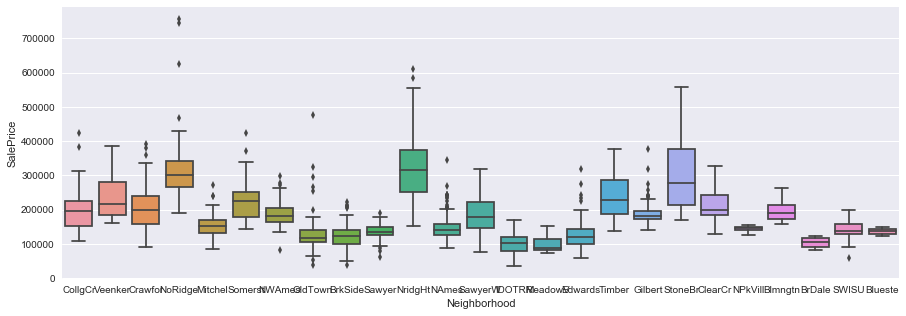

In [8]:
# box plot build decade/saleprice
var = 'Neighborhood'
data = pd.concat([df_train['SalePrice'], (df_train[var])], axis=1)
plt.figure(figsize=(15,5))
sns.boxplot(x=var, y="SalePrice", data=data)

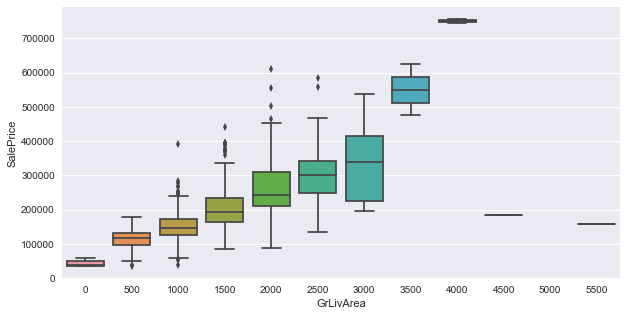

In [9]:
# box plot Ground Living Area/saleprice
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], (df_train[var]//500)*500], axis=1)
plt.figure(figsize=(10,5))
sns.boxplot(x=var, y="SalePrice", data=data)

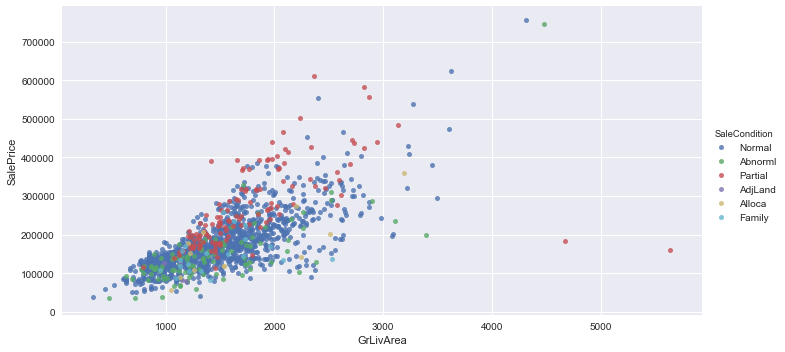

In [10]:
# scatter plot GrLivArea/saleprice
var = 'GrLivArea'
hue = 'SaleCondition'
data = pd.concat([df_train['SalePrice'], df_train[var], df_train[hue]], axis=1)
sns.lmplot(x=var, y="SalePrice", data=data, fit_reg=False, hue=hue, aspect=2, size=5, scatter_kws={"s": 25})

**Which columns have nulls**

In [11]:
any_nulls = pd.DataFrame(df_train.isnull().sum())
any_nulls = any_nulls[any_nulls>0].dropna()

In [12]:
any_nulls

,0
Alley,2721.0
BsmtCond,82.0
BsmtExposure,82.0
BsmtFinSF1,1.0
BsmtFinSF2,1.0
BsmtFinType1,79.0
BsmtFinType2,80.0
BsmtFullBath,2.0
BsmtHalfBath,2.0
BsmtQual,81.0


**Convert Nulls**

In [13]:
# Change Lot Frontage from NA to 0
df_train.loc[:, "LotFrontage"] = df_train.loc[:, "LotFrontage"].fillna(0)
# Change Alley from NA to None
df_train.loc[:, "Alley"] = df_train.loc[:, "Alley"].fillna("None")
# Change Masonry veneer type from NA to None
df_train.loc[:, "MasVnrType"] = df_train.loc[:, "MasVnrType"].fillna("None")
# Change Masonry veneer area from NA to 0
df_train.loc[:, "MasVnrArea"] = df_train.loc[:, "MasVnrArea"].fillna(0)
# Change 333 Basement Finish Type 2 to Unf (same as Type 1)
df_train.loc[332, "BsmtFinType2"] = 'Unf'
# Change Basement Quality from NaN to None
df_train.loc[:, "BsmtQual"] = df_train.loc[:, "BsmtQual"].fillna("None")
# Change Basement Condition from NaN to None
df_train.loc[:, "BsmtCond"] = df_train.loc[:, "BsmtCond"].fillna("None")
# Change Basement Finish Type 1 and 2 from NaN to None
df_train.loc[:, "BsmtFinType1"] = df_train.loc[:, "BsmtFinType1"].fillna("None")
df_train.loc[:, "BsmtFinType2"] = df_train.loc[:, "BsmtFinType2"].fillna("None")
# Change Basement Exposure from NaN to None
df_train.loc[:, "BsmtExposure"] = df_train.loc[:, "BsmtExposure"].fillna("None")
# Change Fireplace Quality from NaN to None
df_train.loc[:, "FireplaceQu"] = df_train.loc[:, "FireplaceQu"].fillna("None")
# Change Garage Type from NaN to None
df_train.loc[:, "GarageType"] = df_train.loc[:, "GarageType"].fillna("None")
# Change Garage Finish from NaN to None
df_train.loc[:, "GarageFinish"] = df_train.loc[:, "GarageFinish"].fillna("None")
# Change Garage Quality from NaN to None
df_train.loc[:, "GarageQual"] = df_train.loc[:, "GarageQual"].fillna("None")
# Change Garage Condition from NaN to None
df_train.loc[:, "GarageCond"] = df_train.loc[:, "GarageCond"].fillna("None")
# Change Pool Quality from NaN to None
df_train.loc[:, "PoolQC"] = df_train.loc[:, "PoolQC"].fillna("None")
# Change Fence from NaN to None
df_train.loc[:, "Fence"] = df_train.loc[:, "Fence"].fillna("None")
# Change Misc Feature from NaN to None
df_train.loc[:, "MiscFeature"] = df_train.loc[:, "MiscFeature"].fillna("None")
# Change Garage Year built to same as Year Built
df_train.loc[:, "GarageYrBlt"] = df_train.loc[:, "GarageYrBlt"].fillna(df_train['YearBuilt'])

# Additional required for test data
# Change MSZoning from NaN to RL (most common)
df_train.loc[:, "MSZoning"] = df_train.loc[:, "MSZoning"].fillna("RL")
# Change Utilities from NaN to AllPub (most common)
df_train.loc[:, "Utilities"] = df_train.loc[:, "Utilities"].fillna("AllPub")
# Change basement NaN to 0 as its all for one record
df_train.loc[:, "BsmtFinSF1"] = df_train.loc[:, "BsmtFinSF1"].fillna(0)
df_train.loc[:, "BsmtFinSF2"] = df_train.loc[:, "BsmtFinSF2"].fillna(0)
df_train.loc[:, "BsmtUnfSF"] = df_train.loc[:, "BsmtUnfSF"].fillna(0)
df_train.loc[:, "TotalBsmtSF"] = df_train.loc[:, "TotalBsmtSF"].fillna(0)
df_train.loc[:, "BsmtFullBath"] = df_train.loc[:, "BsmtFullBath"].fillna(0)
df_train.loc[:, "BsmtHalfBath"] = df_train.loc[:, "BsmtHalfBath"].fillna(0)
# Change Siding from NaN to VinylSd as its the most common
df_train.loc[:, "Exterior1st"] = df_train.loc[:, "Exterior1st"].fillna("VinylSd")
df_train.loc[:, "Exterior2nd"] = df_train.loc[:, "Exterior2nd"].fillna("VinylSd")
# Change KitchenQual from NaN to TA as its the most common
df_train.loc[:, "KitchenQual"] = df_train.loc[:, "KitchenQual"].fillna("TA")
# Change Functional from NaN to Typ as its the most common
df_train.loc[:, "Functional"] = df_train.loc[:, "Functional"].fillna("Typ")
# Change Garage from NaN to the mean
df_train.loc[:, "GarageCars"] = df_train.loc[:, "GarageCars"].fillna(df_train['GarageCars'].mean())
df_train.loc[:, "GarageArea"] = df_train.loc[:, "GarageArea"].fillna(df_train['GarageArea'].mean())
# Change SaleType from NaN to WD as its the most common
df_train.loc[:, "SaleType"] = df_train.loc[:, "SaleType"].fillna("WD")
# change 2550 as its year sold is earlier than year built
df_train.loc[2549, "YearBuilt"] = 2007
df_train.loc[2549, "YearRemodAdd"] = 2007
# change 2296 as its year sold is earlier than remodel
df_train.loc[2295, "YearRemodAdd"] = 2007

**Convert categorical features to strings**

From *A study on Regression applied to the Ames dataset*

In [14]:
df_train = df_train.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                                 "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                       7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                            })

**Other engineered features**

In [15]:
df_train["TotalHouseBsmtSF"] = df_train["1stFlrSF"] + df_train["2ndFlrSF"] + df_train["TotalBsmtSF"]
df_train["TotalBathrooms"] = df_train["BsmtFullBath"] + (0.5* df_train["BsmtHalfBath"]) + df_train["FullBath"] + (0.5*df_train["HalfBath"])
df_train["TotalHouseRooms"] = df_train["TotalBathrooms"] + df_train["TotRmsAbvGrd"]
df_train["AvgRoomSize"] = df_train["TotalHouseBsmtSF"] / df_train["TotalHouseRooms"] 
df_train["AgeAtSale"] = df_train["YrSold"] - df_train["YearBuilt"]
df_train["YrsAfterRenoSold"] = df_train["YrSold"] - df_train["YearRemodAdd"]
df_train["SFperGarage"] = df_train["TotalHouseBsmtSF"] / (df_train["GarageCars"]+1)

In [16]:
# Neighborhood comparison
neighborhood_means = df_train.groupby(["Neighborhood"]).mean()
# Lot Area SF compared to neighbohood
df_train["LotArea_Neighborhood"]= df_train["Neighborhood"].apply(lambda x: neighborhood_means.loc[x,"LotArea"])
df_train["LotArea_Neighborhood"]= (df_train["LotArea"] > df_train["LotArea_Neighborhood"])/df_train["LotArea_Neighborhood"]
# House + Basement SF compared to neighbohood
df_train["TotalHouseBsmtSF_Neighborhood"]= df_train["Neighborhood"].apply(lambda x: neighborhood_means.loc[x,"TotalHouseBsmtSF"])
df_train["TotalHouseBsmtSF_Neighborhood"]= (df_train["TotalHouseBsmtSF"] > df_train["TotalHouseBsmtSF_Neighborhood"])/df_train["TotalHouseBsmtSF_Neighborhood"]
# Age of house vs Neighborhood
df_train["YearBuilt_Neigborhood"]= df_train["Neighborhood"].apply(lambda x: neighborhood_means.loc[x,"YearBuilt"])
df_train["YearBuilt_Neigborhood"]= (df_train["YearBuilt"] > (df_train["YearBuilt_Neigborhood"]))
# Age of renovation vs Neighborhood
df_train["YearRemodAdd_Neigborhood"]= df_train["Neighborhood"].apply(lambda x: neighborhood_means.loc[x,"YearRemodAdd"])
df_train["YearRemodAdd_Neigborhood"]= (df_train["YearRemodAdd"] > (df_train["YearRemodAdd_Neigborhood"]))
# Overall Quality vs Neighborhood
df_train["OverallQual_Neigborhood"]= df_train["Neighborhood"].apply(lambda x: neighborhood_means.loc[x,"OverallQual"])
df_train["OverallQual_Neigborhood"]= (df_train["OverallQual"] > (df_train["OverallQual_Neigborhood"]))
# Overall Condition vs Neighborhood
df_train["OverallCond_Neigborhood"]= df_train["Neighborhood"].apply(lambda x: neighborhood_means.loc[x,"OverallCond"])
df_train["OverallCond_Neigborhood"]= (df_train["OverallCond"] > (df_train["OverallCond_Neigborhood"]))
# Room size vs Neighborhood
df_train["AvgRoomSize_Neigborhood"]= df_train["Neighborhood"].apply(lambda x: neighborhood_means.loc[x,"AvgRoomSize"])
df_train["AvgRoomSize_Neigborhood"]= (df_train["AvgRoomSize"] > (df_train["AvgRoomSize_Neigborhood"]))

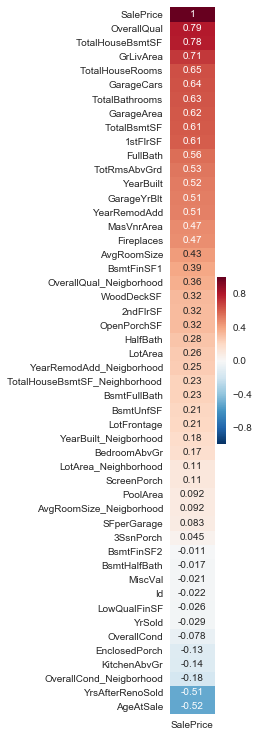

In [17]:
corrmat = df_train.corr()
indices = corrmat.loc[:,'SalePrice'].copy()
a = pd.DataFrame(indices.sort_values(ascending=False))
plt.figure(figsize=(1,13))
sns.heatmap(a, annot=True)

**Drop crappy data**

Tried including more SaleTypes and Saleconditions but normal seemed to work better

In [18]:
# Drop 949 as has a basement but NA for exposure
df_train.drop(948, inplace=True)


# Drop 1380 as no electrical
df_train.drop(1379, inplace=True)
# Drop those entries that have lot area larger than 100000ft (but keep all "test" data)
df_train = df_train[(df_train['LotArea'] < 100000) | (df_train['Id'].isin(df_test["Id"]))]
# Only include sales where house is in normal condition (but keep all "test" data)
df_train = df_train[(df_train['SaleCondition'] == 'Normal') | (df_train['Id'].isin(df_test["Id"]))]
# Only include conventional sales(but keep all "test" data)
df_train = df_train[(df_train['SaleType'] == 'WD') | (df_train['Id'].isin(df_test["Id"]))]

**Drop other features**

In [19]:
# Drop MiscVal as it contains different types of data
df_train.drop('MiscVal', axis=1, inplace=True)
# Add target variable and drop Sale Price
y_SalePrice = pd.DataFrame(df_train['SalePrice'], columns=['SalePrice']).dropna().copy()
df_train.drop('SalePrice', axis=1, inplace=True)

**Remove skewness in numeric features**

In [23]:
# Get numeric features of current df_train
numeric_feats = df_train.dtypes[(df_train.dtypes != "object") & (df_train.dtypes != "bool")].index

# Update columns with log1p if skewness  .1
skewed = df_train[numeric_feats].apply(lambda x: abs(stats.skew(x.dropna()))) #compute skewness

# drop Id column
skewed = skewed.drop(['Id'])
skewed_feats = skewed[(skewed>.1)].index

df_train[skewed_feats] = np.log1p(df_train[skewed_feats])

y_SalePrice = np.log1p(y_SalePrice)

**Get dummies for categorical features**

In [24]:
cat_feats = df_train.dtypes[(df_train.dtypes == "object") | (df_train.dtypes == "bool")].index

df_train_cat = pd.get_dummies(df_train.loc[:,cat_feats])
df_train_num = df_train.loc[:,numeric_feats].copy()
df_train = pd.concat([df_train_num,df_train_cat], axis=1)

**Create new Polynomials on some top existing features**

Am I meant to create these before or after normalizing?

**Split out the testing and training data again**

In [25]:
df_test = df_train[df_train['Id'].isin(df_test['Id'])].copy()
df_train = df_train[df_train['Id'].isin(df_initial_train['Id'])]

**Scaled dataframe**

In [26]:
# Scale the numerical features to create a scaled df for SelectFromModel
scaler = RobustScaler()
df_train_scaled = df_train.copy()
df_train_scaled.loc[:,:] = scaler.fit_transform(df_train.loc[:,:])

**Define some functions to help with predictions**

Borrowed from some of this from *A study on Regression applied to the Ames dataset*

In [27]:
def format_good_features(good_feats, df):
    #Format the Dataframe with only the good features selected from the SelectFromModel
    
    good_feats_index = good_feats.get_support()
    good_feats_columns = df.columns[good_feats_index]
    
    return df.loc[:,good_feats_columns]

In [28]:
def split_scale(X, y, scaler_function=RobustScaler()):
    # train_test_split then scale the features  
    
    X_train, X_test, y_train, y_test = train_test_split(X.copy(), y.copy(), test_size=0.3, random_state=42)

    scaler2 = scaler_function
    X_train.loc[:,:] = scaler2.fit_transform(X_train.loc[:,:])
    X_test.loc[:,:] = scaler2.fit_transform(X_test.loc[:,:])
    
    return X_train, X_test, y_train, y_test

In [29]:
def centered_alpha(alpha):
    # Get new alphas for testing centered around previous best alpha
    
    return np.ravel([alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, alpha * .9, alpha * .95, 
              alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4])

In [30]:
def output_findings(model, name, df_train, y_test, y_train, column_name, y_train_model, y_test_model):
    # Output a plot of important coefficients and show the RMSE for the training and test data
    
    # Plot important coefficients
    coefs = pd.Series(np.ravel(model.coef_), index = np.ravel(df_train.columns))
    print(name + " picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
          str(sum(coefs == 0)) + " features")
    imp_coefs = pd.concat([coefs.sort_values().head(10),
                         coefs.sort_values().tail(10)])
    imp_coefs.plot(kind = "barh")
    plt.title("Coefficients in the "+ name + " Model")
    plt.show()

    #Show RMSE
    print("RMSE Training Data:",np.sqrt(mean_squared_error(np.log1p(np.expm1(y_train)),
                                                           np.log1p(np.expm1(y_train_model)))))
    print("RMSE Testing Data: ",np.sqrt(mean_squared_error(np.log1p(np.expm1(y_test)),
                                                           np.log1p(np.expm1(y_test_model)))))

**RidgeCV**

Best alpha : 2
Try again for more precision with alphas centered around 2
Best alpha : 2.6
RidgeCV picked 124 features and eliminated the other 1 features


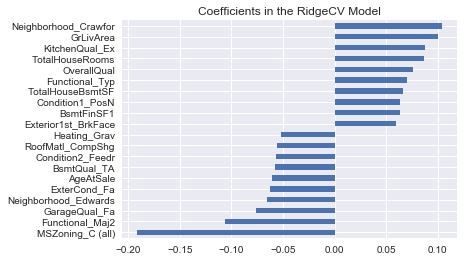

RMSE Training Data: 0.0743596123226
RMSE Testing Data:  0.0933989115819


In [31]:
# Set initial variables
alphas = [.3, 1, 2, 5, 10, 100]
cv = KFold(20,True,42)
gcv_mode = 'auto'
scoring = 'neg_mean_squared_error'

#Features based on SelectFromModel(RidgeCV)
clf = RidgeCV(alphas = alphas, cv=cv, gcv_mode=gcv_mode, scoring=scoring)
good_feats_ridge = SelectFromModel(clf,threshold="mean").fit(df_train_scaled,y_SalePrice)

# Format training data
df_train_ridge = format_good_features(good_feats_ridge, df_train)

# train_test_split and scale
X_train, X_test, y_train, y_test = split_scale(df_train_ridge, y_SalePrice, scaler_function=RobustScaler())

# Run RidgeCV to find best alphas
ridge = RidgeCV(alphas = alphas, cv=cv, gcv_mode=gcv_mode, scoring=scoring)
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

# Get even better alphas
print("Try again for more precision with alphas centered around " + str(alpha))
ridge = RidgeCV(alphas = centered_alpha(alpha), cv = cv, gcv_mode=gcv_mode, scoring=scoring)
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

# Run predictions
y_train_ridge = ridge.predict(X_train)
y_test_ridge = ridge.predict(X_test)

# Output findings
output_findings(ridge, "RidgeCV", df_train_ridge, y_test, y_train, "SalePrice", y_train_ridge, y_test_ridge)


**LassoCV**

C:\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Best alpha : 0.0001
Try again for more precision with alphas centered around 0.0001
Best alpha : 0.000125
LassoCV picked 78 features and eliminated the other 3 features


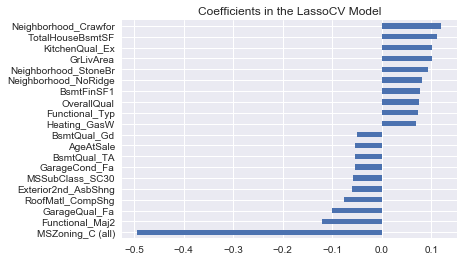

RMSE Training Data: 0.0759711587397
RMSE Testing Data:  0.0942417269157


In [32]:
# Set initial variables
alphas = [.00001, .00003, .0001, .0003]
max_iter = 15000
cv = KFold(10,True,42)

#Features based on SelectFromModel(LassoCV)
clf = LassoCV(alphas = np.ravel(alphas), max_iter = max_iter, cv = cv)
good_feats_lasso = SelectFromModel(clf,threshold="mean").fit(df_train_scaled,np.ravel(y_SalePrice))

# Format training data
df_train_lasso = format_good_features(good_feats_lasso, df_train)

# train_test_split and scale
X_train, X_test, y_train, y_test = split_scale(df_train_lasso, y_SalePrice)

# Run LassoCV to find best alphas
lasso = LassoCV(alphas = np.ravel(alphas), max_iter = max_iter, cv = cv)
lasso.fit(X_train, np.ravel(y_train))
alpha = lasso.alpha_
print("Best alpha :", alpha)

# Get even better alphas
print("Try again for more precision with alphas centered around " + str(alpha))
lasso = LassoCV(alphas = np.ravel(centered_alpha(alpha)), max_iter = max_iter, cv = cv)
lasso.fit(X_train, np.ravel(y_train))
alpha = lasso.alpha_
print("Best alpha :", alpha)

# Run predictions
y_train_lasso = lasso.predict(X_train)
y_test_lasso = lasso.predict(X_test)

# Output findings
output_findings(lasso, "LassoCV", df_train_lasso, y_test, y_train, "SalePrice", y_train_lasso, y_test_lasso)

**BayesianRidge**

Convergence after  10  iterations
BayesianRidge picked 126 features and eliminated the other 0 features


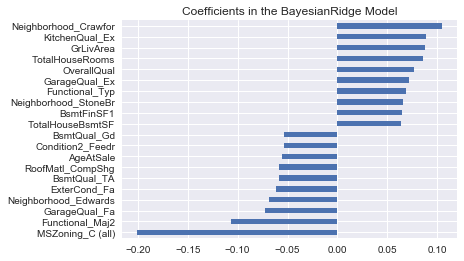

RMSE Training Data: 0.0736202236085
RMSE Testing Data:  0.0923213020886


In [33]:
# Set initial variables
n_iter = 300

#Features based on SelectFromModel(BayesianRidge)
clf = BayesianRidge(n_iter = n_iter)
good_feats_bayes = SelectFromModel(clf,threshold="mean").fit(df_train_scaled,np.ravel(y_SalePrice))

# Format training data
df_train_bayes = format_good_features(good_feats_bayes, df_train)

# train_test_split and scale
X_train, X_test, y_train, y_test = split_scale(df_train_bayes, y_SalePrice)

# Run BayesianRidge (ran some tests to find best alpha - changing it had no impact)
bayes = BayesianRidge(n_iter = n_iter, verbose=True)
bayes.fit(X_train, np.ravel(y_train))

# Run predictions
y_train_bayes = bayes.predict(X_train)
y_test_bayes = bayes.predict(X_test)

# Output findings
output_findings(bayes, "BayesianRidge", df_train_bayes, y_test, y_train, "SalePrice", y_train_bayes, y_test_bayes)

**RandomForestRegressor**


RandomForestRegressor picked 24 features and eliminated the other 0 features


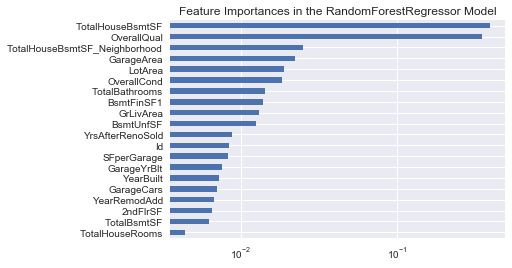

RMSE Training Data: 0.00348166132256
RMSE Testing Data: 0.0100830971245


In [34]:
# Set initial variables
n_estimators = 200

#Features based on SelectFromModel(RandomForestRegressor)
clf = RandomForestRegressor(n_estimators=n_estimators)
good_feats_rfr = SelectFromModel(clf,threshold="mean").fit(df_train_scaled,np.ravel(y_SalePrice))

# Format training data
df_train_rfr = format_good_features(good_feats_rfr, df_train)

# train_test_split and scale
X_train, X_test, y_train, y_test = split_scale(df_train_rfr, y_SalePrice)

# Run RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=n_estimators)
rfr.fit(X_train, np.ravel(y_train))

# Run predictions
y_train_rfr = rfr.predict(X_train)
y_test_rfr = rfr.predict(X_test)

# Output findings - cant use function as this uses .feature_importances_ rather than coefs_
# Plot important coefficients
coefs = pd.Series(rfr.feature_importances_, index = df_train_rfr.columns)
print("RandomForestRegressor picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
coefs = coefs[coefs !=0]
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Feature Importances in the RandomForestRegressor Model")
plt.xscale('log')
plt.show()

# Show RSME
print("RMSE Training Data:",np.sqrt(mean_squared_error(np.log1p(y_train),np.log1p(y_train_rfr))))
print("RMSE Testing Data:",np.sqrt(mean_squared_error(np.log1p(y_test),np.log1p(y_test_rfr))))

# Predictions from each model

In [35]:
def get_predictions(model, filename, good_features, df):
    # Get right features
    df_model_test = format_good_features(good_features, df)
    # Scale the features
    scaler2 = RobustScaler()
    df_model_test.loc[:,:] = scaler2.fit_transform(df_model_test.loc[:,:])
    # Predict
    predictions = model.predict(df_model_test)
    predictions = pd.DataFrame(predictions, index=df['Id'], columns=['SalePrice'])
    # Get real prices and save to csv
    predictions = np.expm1(predictions)
    predictions.to_csv(filename, index_label='Id')
    return predictions

In [36]:
def mean_of_models(models, filename, index):
    mean_model = pd.concat(models, axis=1)
    mean_model = mean_model.mean(axis=1)
    test_mean = pd.DataFrame(mean_model, index=index, columns=['SalePrice'])
    test_mean.to_csv(filename, index_label='Id')
    return test_mean

**Ridge**

In [37]:
test_ridge = get_predictions(ridge, 'test_ridge.csv', good_feats_ridge, df_test)

**Lasso**

In [38]:
test_lasso = get_predictions(lasso, 'test_lasso.csv', good_feats_lasso, df_test)

**BayesianRidge**

In [39]:
test_bayes = get_predictions(bayes, 'test_bayes.csv', good_feats_bayes, df_test)

**RandomForestsRegressor**

In [40]:
test_rfr = get_predictions(rfr, 'test_rfr.csv', good_feats_rfr, df_test)

**Mean of all models**

In [41]:
# Mean difference of model from mean of all models
differ = pd.concat([test_bayes, test_ridge, test_lasso, test_rfr], axis=1)
differ.set_axis(1, ['test_bayes', 'test_ridge', 'test_lasso', 'test_rfr'])
differ['mean'] = differ.mean(axis=1)
differ['diff_bayes'] = (differ.loc[:,'mean'] - differ.loc[:,'test_bayes']) / differ.loc[:,'test_bayes']
#differ['diff_elas'] = (differ.loc[:,'mean'] - differ.loc[:,'test_elas']) / differ.loc[:,'test_elas']
differ['diff_ridge'] = (differ.loc[:,'mean'] - differ.loc[:,'test_ridge']) / differ.loc[:,'test_ridge']
differ['diff_lasso'] = (differ.loc[:,'mean'] - differ.loc[:,'test_lasso']) / differ.loc[:,'test_lasso']
differ['diff_rfr'] = (differ.loc[:,'mean'] - differ.loc[:,'test_rfr']) / differ.loc[:,'test_rfr']

# some stats on the models
absdiff = differ.abs().mean()[-4:]
avgdiff = differ.mean()[-4:]
stddiff = differ.std()[-4:]
ltdiff = differ.iloc[:,-4:][differ.iloc[:,-4:]<0].count()
gtdiff = differ.iloc[:,-4:][differ.iloc[:,-4:]>0].count()
avgltdiff = differ.iloc[:,-4:][differ.iloc[:,-4:]<0].mean()
avggtdiff = differ.iloc[:,-4:][differ.iloc[:,-4:]>0].mean()

# Absolute Difference, Average Difference, Count less than mean, Count greater than mean, 
# Average of those less than mean, Average of those greater than mean
differ2 = pd.concat([absdiff, avgdiff, ltdiff, gtdiff, avgltdiff, avggtdiff], axis=1, 
                    keys=['absdiff', 'avgdiff', 'ltdiff', 'gtdiff', 'avgltdiff', 'avggtdiff'])
differ2

,absdiff,avgdiff,ltdiff,gtdiff,avgltdiff,avggtdiff
diff_bayes,0.023906,-0.008515,979,480,-0.024159,0.023390
diff_ridge,0.022861,-0.004919,890,569,-0.022770,0.023003
diff_lasso,0.027237,0.010789,627,832,-0.019138,0.033341
diff_rfr,0.062813,0.014367,618,841,-0.057186,0.066948


In [42]:
mean_of_models([test_bayes, test_ridge, test_lasso, test_rfr], 'test_mean_all.csv', df_test['Id'])

,SalePrice
Id,
1461,116527.472633
1462,165583.879029
1463,184141.184988
1464,194885.550926
1465,192129.455218
1466,173779.342076
1467,178436.925802
1468,164991.372673
1469,196696.298692


In [43]:
# try some different combos
mean_of_models([test_bayes, test_ridge, test_lasso], 'test_mean_bayes_ridge_lasso.csv', df_test['Id'])

,SalePrice
Id,
1461,112283.269865
1462,165164.444202
1463,187079.961401
1464,202852.216218
1465,192159.193344
1466,172347.960502
1467,180154.183548
1468,165640.753534
1469,200809.787819
